# RELIKE - Reionization Effective Likelihood 

## Example 1. Comparing The Likelihood Ratio of Tanh Models 

### 1. Create a PC object which contains all PC related operations. 

Create a PC object using `relike.PC()`. The ionization fraction can be fully described as $x_e(z) = x_e^{\rm fid}(z) + \sum_{j=1}^{n_{\rm PC}} m_j S_j(z)$ with all $n_{\rm PC} = 95$ PCs, but only $n_{\rm PC} = 5$ are needed to describe within cosmic variance, the observational impact of any model between $6 < z < 30$ on the low-$\ell$ CMB polarization power spectrum $C_l^{EE}$. To plot out the first 5 PC functions $S_j(z)$ and the fiducial model, use `pc.plot_pc()`.

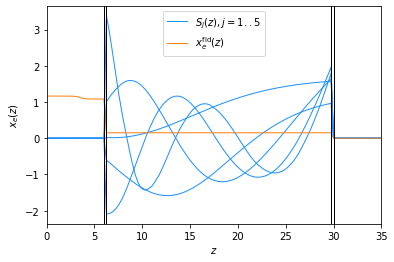

In [1]:
import relike
pc = relike.PC()
pc.plot_pc()

Note that the PC functions are linearly interpolated between the vertical lines (showing bin width $dz = 0.25$). We interpolate $S_j(z)$ to 0 on either side of $6 < z < 30$; and for the fiducial $x_e^{\rm fid}(z)$ function, it is interpolated to 0 for $z \leq 30$ and to fully ionized Universe for $z \leq 6$, where fully ionized here means, fully ionized hydrogen and singly helium ionized for all of $z \leq6$, with the second helium ionization occuring at $z = 3.5$.

### 2. Create a $x_e(z)$ function and get its PC amplitudes $m_j$'s. 

Here we make use a provided class `TanhModel` in `relike`, but you can use any python function defined on $6 < z < 30$.

In [2]:
tanh_model = relike.TanhModel()
xe_func = tanh_model.get_xe_func(zre=10.0) 

mjs = pc.get_mjs(xe_func)
print('mjs = {}'.format(mjs))

mjs = [-0.11712834 -0.09884358  0.21770627 -0.22767822  0.1037556 ]


**BE CAREFUL**: We want the $x_e(z)$ model to be fully ionized by 6, so in the tanh model, this means that we want to take into account the transition width of the tanh function in this model $dz = 0.015(1+z) \sim 0.1$ around $z = 6$, we cannot use this model with $z_{\rm re} < 6.1$ for inferring the likelihood with PCs.

### 3. Get the effective likelihood for your $x_e(z)$ model. 
This python package supports the Gaussian likelihood mode only , which was shown to be good enough for typical models in Heinrich & Hu 2021 [add arxiv number]. 
Note: The kernel density estimate (KDE) mode is not supported here, but is available in our CosmoMC implementation in Fortran.

In [3]:
gauss_like = relike.GaussianLikelihood()
loglike = gauss_like.get_loglike(mjs)
print('loglike = {}'.format(loglike))

loglike = -4.902806303700334


Note that we have normalized the `loglike` value to the best-fit tanh model in Planck 2018.  

In [12]:
xe_func_bf = tanh_model.get_xe_func(zre=8.1)
mjs_bf = pc.get_mjs(xe_func_bf)
loglike_bf = gauss_like.get_loglike(mjs_bf)
print('loglike_bf = {}'.format(loglike_bf))

loglike_bf = 0.0


So you can directly get a sense of how well your model fit by comparison via a likelihood ratio or $\Delta \chi^2$:

In [21]:
likelihood_ratio = np.exp(loglike)
print('The likelihood ratio between my model (tanh zre = 10.0) and the best-fit tanh model (zre = 8.1) is: {}'.format(likelihood_ratio))

delta_chi2 = -2.0 * (loglike)
print('My model (tanh zre = 10.0) is worse than the best-fit tanh model (zre = 8.1) by a delta chi2 of: {}'.format(delta_chi2))


The likelihood ratio between my model (tanh zre = 10.0) and the best-fit tanh model (zre = 8.1) is: 0.007425714992076272
My model (tanh zre = 10.0) is worse than the best-fit tanh model (zre = 8.1) by a delta chi2 of: 9.805612607400668


Note that the best-fit tanh model is not the best-fit model in entire space of physical models, so you may find a model that fits slightly better than tanh in Planck 2018 (e.g. see our two-step model in Heinrich & Hu 2021). 

## Example 2. Plot posterior for an 1-parameter model 

### 1. Obtain likelihoods for a list of tau values

In [22]:
import relike
import numpy as np

pc = relike.PC()
use_fiducial_cosmology = True
gauss_like = relike.GaussianLikelihood()

zre_values = np.linspace(6.1, 10.5, 101)
tau_values = np.zeros_like(zre_values)
likelihood = np.zeros_like(zre_values)

for i, zre in enumerate(zre_values):
    tanh_model = relike.TanhModel()
    xe_func = tanh_model.get_xe_func(zre=zre)
    mjs = pc.get_mjs(xe_func)
    tau_values[i] = pc.get_tau(mjs)
    likelihood[i] = np.exp(gauss_like.get_loglike(mjs))

Note that we are using `pc.get_tau` to obtain the PC estimates of $\tau$ for each tanh model of a given $z_{\rm re}$. These are not the same as integrating the exact $x_e(z)$, but gives accurate enough estimate $\tau$.

### 2. Assuming flat prior in $\tau$, plot its posterior

Note that by plotting directly the normalized likelihoods as the posterior, we are assuming a flat prior in the parameter of interest, namely $\tau$ here. Recall that this is a direct evaluation of the posterior values, not a MCMC sampling. To do that, consider connecting the python relike to a sampler such as Cobaya/Cosmosis, or use our provided CosmoMC-relike package in the same repo.

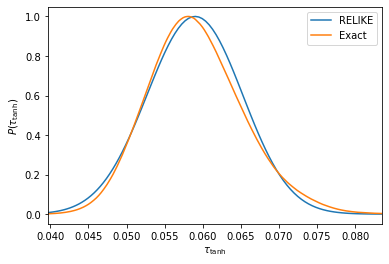

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(tau_values, likelihood/np.max(likelihood), label = 'RELIKE (direct eval.)')
ax.set_xlabel(r'$\tau$')
ax.set_ylabel(r'$P(\tau)$')
ax.set_xlim([tau_values[0], tau_values[-1]])

import os
example_dir = os.getcwd()
fn = 'tau_posterior_pl18_tanh_pliklite_srollv2_dz_auto.dat'
fn = os.path.join(example_dir, 'data/', fn)
data = np.genfromtxt(fn)
ax.plot(data[:,0], data[:,1], label = 'Exact (MCMC sampling)')

ax.legend()

Now you can use any model of $x_e(z)$ that you want and plot its parameter posterior quickly using `relike`! For high dimensional parameter space, we recommend sampling using a MCMC sampler, so that you can also obtain marginalized posterior distributions easily using for example the `getdist` package. Alternatively, you can write your own code for deriving those statistics from an evaluation of the posterior on a grid of parameter values by using the `relike` python package as shown above. 